# Library Imports

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# #1

# Import Data // Remove Null Data

In [ ]:
#1: Importing the data set
df = pd.read_csv('SolarEnergyData.csv')
df = df.dropna(); #removed rows with NaN entries
df = df.reset_index(drop=True)
display(df)

FileNotFoundError: ignored

# #2

# Initial Pairplot

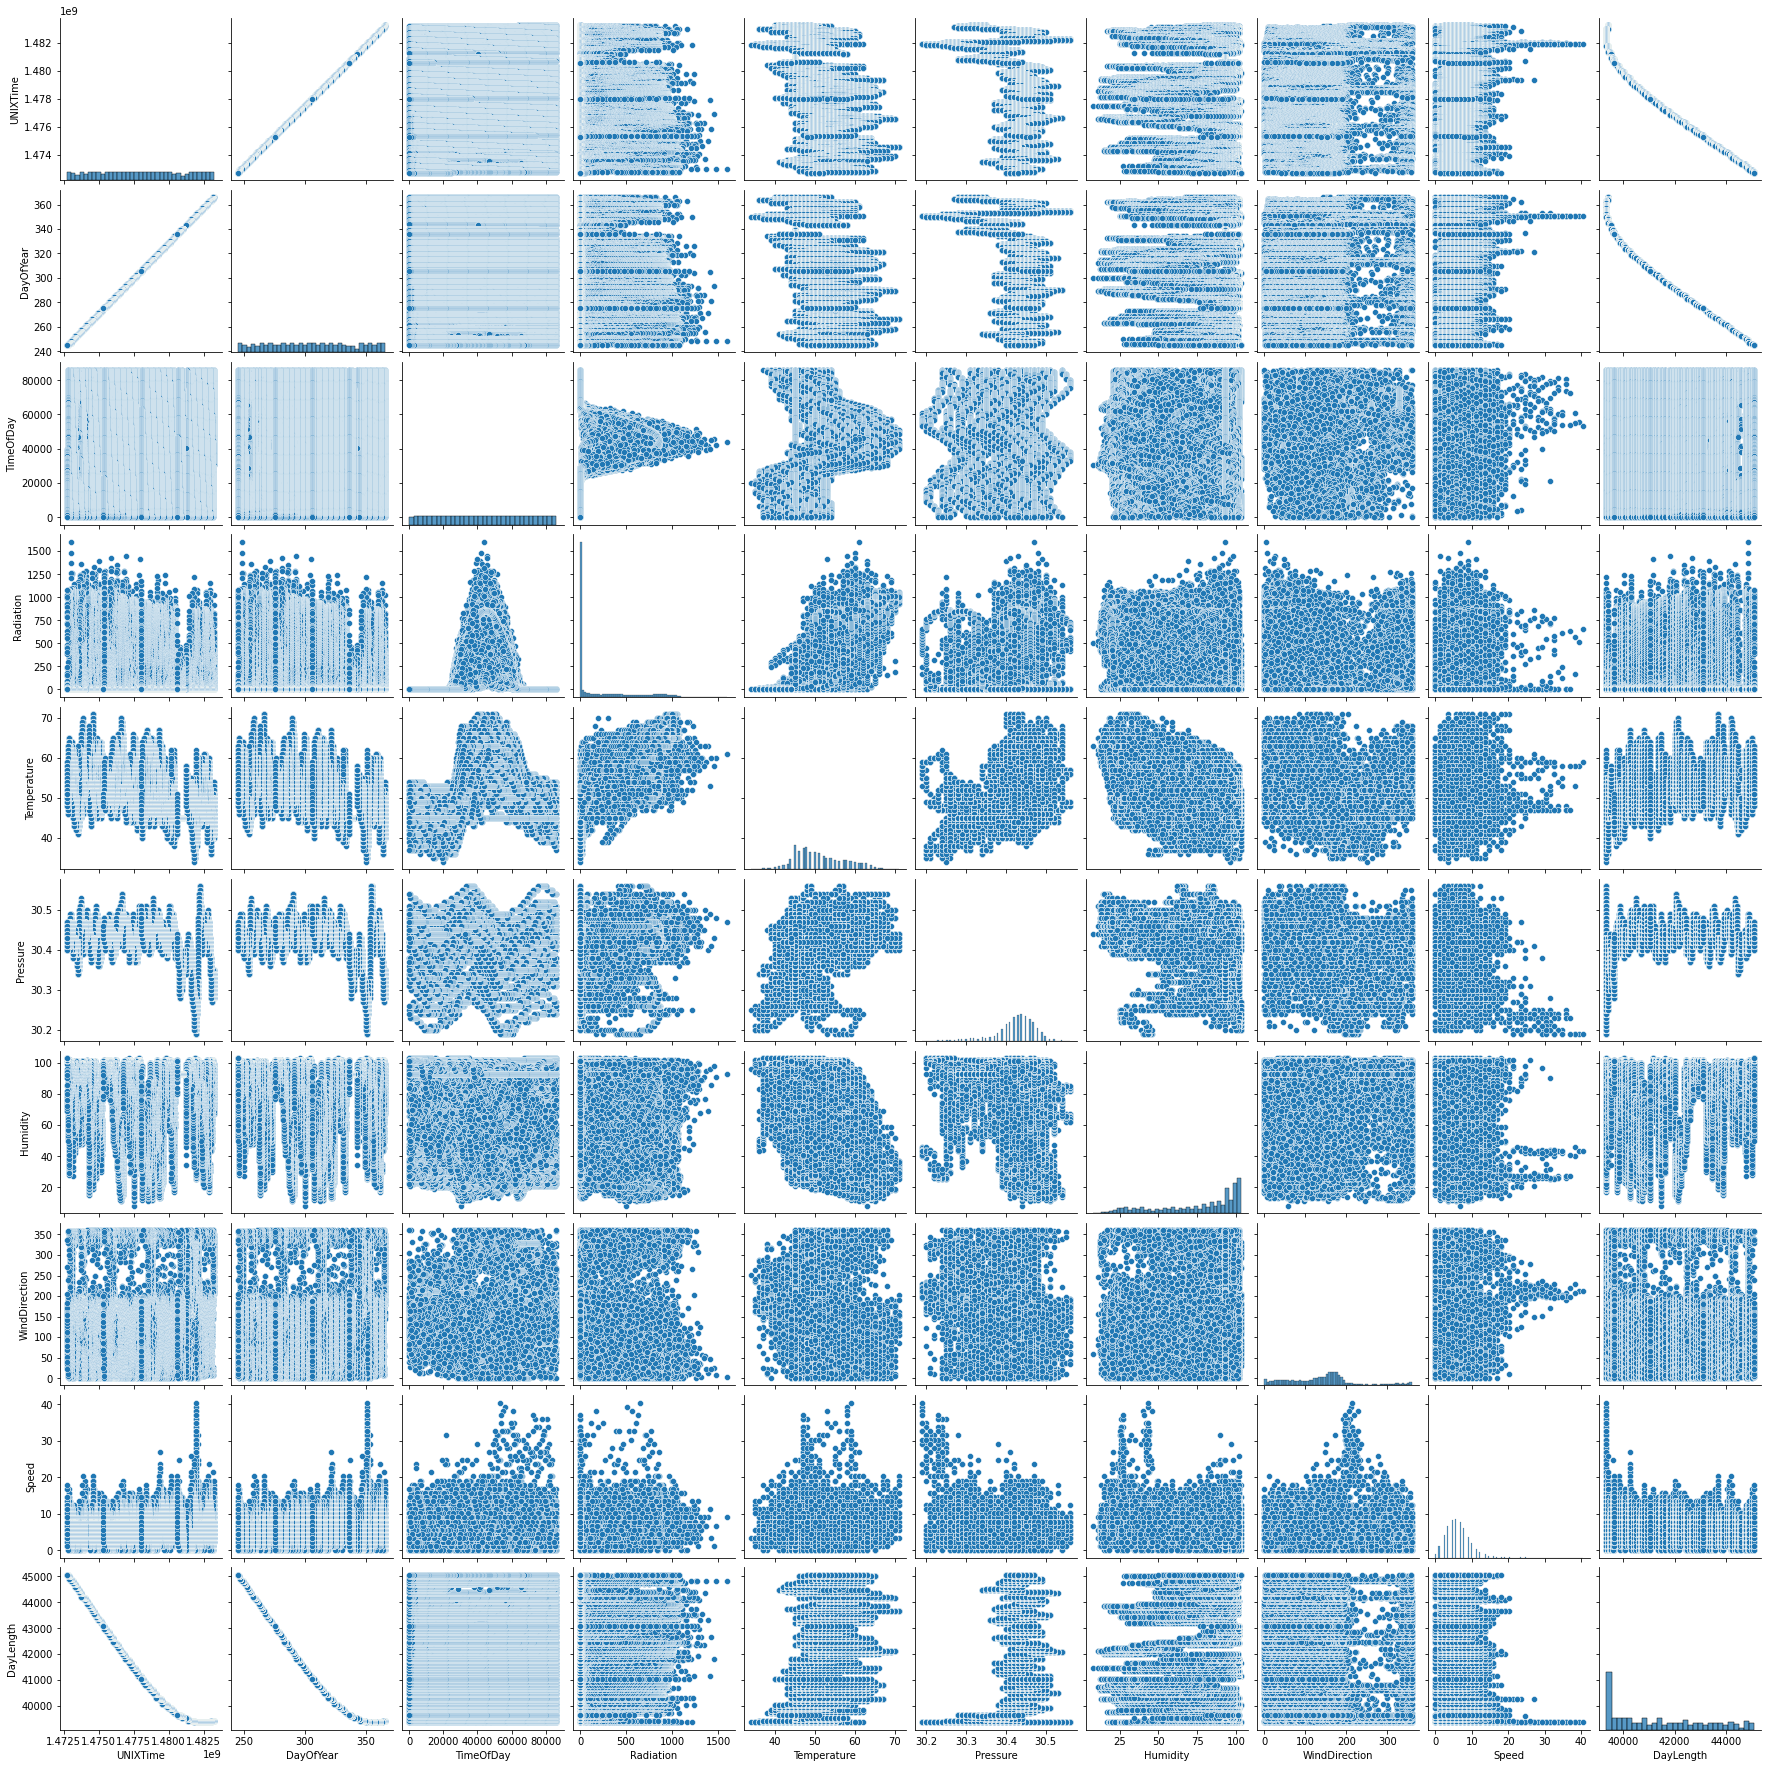

In [ ]:
#sp = sns.pairplot(df.sample(frac=0.025))
sp = sns.pairplot(df)

## Feature Engineering

In [ ]:
#CANNOT RERUN WITHOUT RELOADING DF BECAUSE OF LABEL CHANGE

#DayOfYear
dateTime = pd.to_datetime(df['Date'])
dayOfYear = dateTime
for index, i in enumerate(dateTime):
  dayOfYear[index] = i.timetuple().tm_yday

#MonthOfYear
date = df['Date'].values.astype('str')
month = date
for index, i in enumerate(date):
  (m,d,y) = i.split('/')
  month[index] = int(m)
MonthOfYear = month

#TimeOfDay (in seconds)
time = df['Time'].values.astype('str')
for index, i in enumerate(time):
  (th,tm,ts) = i.split(':')
  time[index] = int(th) * 3600 + int(tm) * 60 + int(ts)
time = time.astype('int')
TimeOfDay = time

#DayLength (in seconds)
sunRise = df['TimeSunRise'].values.astype('str')
for index, i in enumerate(sunRise):
  (sRh, sRm, sRs) = i.split(':')
  sunRise[index] = int(sRh) * 3600 + int(sRm) * 60 + int(sRs) 
sunRise = sunRise.astype('int')

sunSet = df['TimeSunSet'].values.astype('str')
for index, i in enumerate(sunSet):
  (sSh, sSm, sSs) = i.split(':')
  sunSet[index] = int(sSh) * 3600 + int(sSm) * 60 + int(sSs)
sunSet = sunSet.astype('int')
DayLength = sunSet - sunRise

#Assigning modified features to old feature columns and renaming
df['Date'] = dayOfYear
df['Time'] = TimeOfDay
df['TimeSunRise'] = MonthOfYear
df['TimeSunSet'] = DayLength
df.rename(columns={'Date':"DayOfYear",'Time':"TimeOfDay",'TimeSunRise':"MonthOfYear",'TimeSunSet':"DayLength"},inplace = True)
print(df)

         UNIXTime DayOfYear  TimeOfDay  Radiation  Temperature  Pressure  \
0      1475229326       273      86126       1.21           48     30.46   
1      1475229023       273      85823       1.21           48     30.46   
2      1475228726       273      85526       1.23           48     30.46   
3      1475228421       273      85221       1.21           48     30.46   
4      1475228124       273      84924       1.17           48     30.46   
...           ...       ...        ...        ...          ...       ...   
32672  1480587604       336       1204       1.22           44     30.43   
32673  1480587301       336        901       1.17           44     30.42   
32674  1480587001       336        601       1.20           44     30.42   
32675  1480586702       336        302       1.23           44     30.42   
32676  1480586402       336          2       1.20           44     30.43   

       Humidity  WindDirection  Speed MonthOfYear  DayLength  
0          59.0         

# #3

# Pearson Correlations

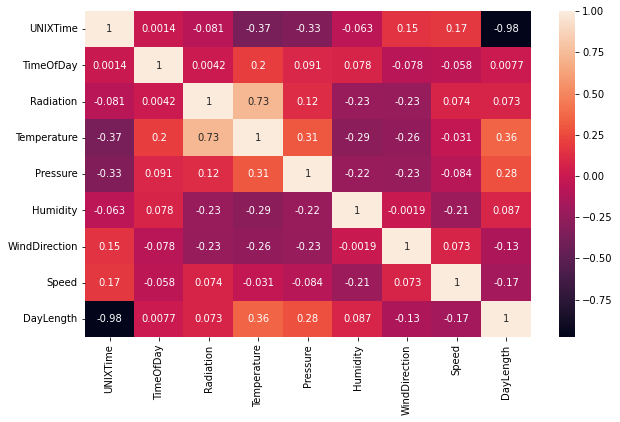

In [ ]:
corr = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot = True)

Investigate linear correlations between the features. Discuss your findings.

# Feature Standardization // PCA

Text(0.5, 0, 'Principal Component')

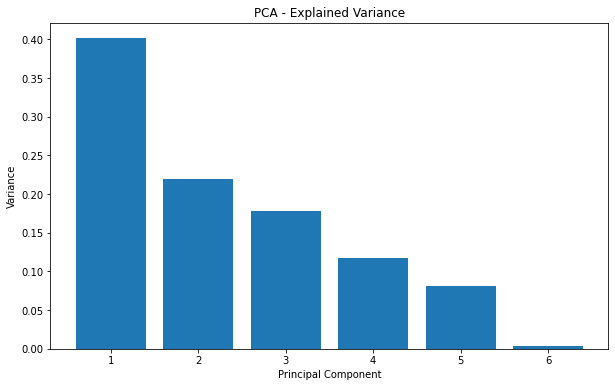

In [ ]:
#need to try multiple different train test splits and generate images that 
#support our reasoning for choosing the best train test split


scaler = StandardScaler()
dfLabels = df.columns


dfStandard = pd.DataFrame(scaler.fit_transform(df))
dfStandard.columns = dfLabels


#features that have the most impact are TimeOfDay, Temperature, Pressure, Humidity, DayLength, and DayOfYear
X = dfStandard[['DayOfYear','TimeOfDay','Temperature','Pressure','Humidity','DayLength']]
y = dfStandard['Radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.25), random_state=42)
  

pca = PCA() 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
t = [1,2,3,4,5,6]
plt.figure(figsize=(10,6))



plt.bar(t,pca.explained_variance_ratio_)
plt.title("PCA - Explained Variance")
plt.ylabel("Variance")
plt.xlabel("Principal Component")

In [ ]:
#first 4 pca's explain 90% of variance; good enough
X_train_pca4 = X_train_pca[:,[0,1,2,3]]
X_test_pca4 = X_test_pca[:,[0,1,2,3]]

# Post Feature Engineering Pairplot

Text(0, 0.5, 'Solar Energy (J/m^2)')

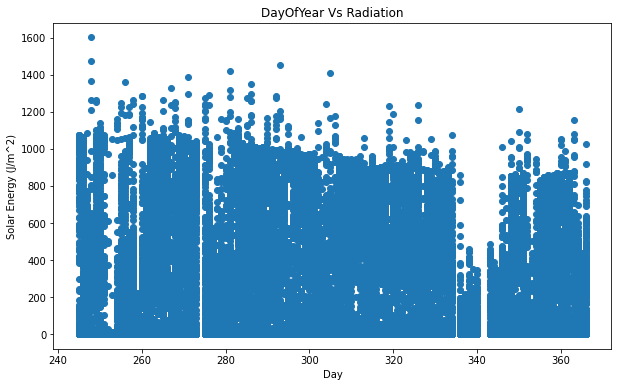

In [ ]:
#sp = sns.pairplot(dfStandard)
plt.figure(figsize=(10,6))
plt.scatter(df['DayOfYear'],df['Radiation'])
plt.title('DayOfYear Vs Radiation')
plt.xlabel('Day')
plt.ylabel('Solar Energy (J/m^2)')

# KNeighbors Regressor FINALIZED
* Mean Absolute Error: 0.11375673277374167
* Mean Squared Error: 0.08235691935620455
* Root Mean Squared Error: 0.28697895281048846
* Coefficient of Determination: 0.9162878961008022



In [ ]:
params = {
    'n_neighbors' : [2,3,4,5,6]
}
knr = GridSearchCV(KNeighborsRegressor(p=2),params,verbose = 1, n_jobs = -1, cv=5)


knr.fit(X_train_pca4,y_train)
print(knr.best_params_)
print()
y_pred_test = knr.predict(X_test_pca4)
y_pred_train = knr.predict(X_train_pca4)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_test))
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Coefficient of Determination:', metrics.r2_score(y_train,y_pred_train))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_neighbors': 4}

Mean Absolute Error: 0.11519618309467923
Mean Squared Error: 0.08416124346749673
Root Mean Squared Error: 0.2901055729686983
Coefficient of Determination: 0.915110406367956

Mean Absolute Error: 0.08532270683010318
Mean Squared Error: 0.04627118356673247
Root Mean Squared Error: 0.21510737683011355
Coefficient of Determination: 0.9538584943599491


In [ ]:

#manual hyperparameter tuning
error_rate_test = []  
error_rate_train = []
difference = []
for i in range(1,20):
  knr = KNeighborsRegressor(n_neighbors = i, weights="uniform", p=2)
  knr.fit(X_train, y_train)
  pred_test = knr.predict(X_test)
  error_rate_test.append(mean_squared_error(y_test,pred_test))
  pred_train = knr.predict(X_train)
  error_rate_train.append(mean_squared_error(y_train,pred_train))
  difference.append(mean_squared_error(y_test,pred_test)-mean_squared_error(y_train,pred_train))

plt.figure(figsize=(10,6))  
plt.plot(range(1,20),error_rate_test,color='blue',linestyle='dashed')
plt.plot(range(1,20),error_rate_train,color='red',linestyle='dashed')

plt.xlabel('no. of K')
plt.ylabel('MSE')
plt.title('Train vs Test MSE')

plt.figure(figsize=(10,6))
plt.plot(range(1,20),difference,color='red',linestyle='dashed')
plt.xlabel('no. of K')
plt.ylabel('Difference MSE')
plt.title('Difference between Test and Train MSE')

  
# 4 is the best n_neighbors (lowest mean squared error, highest r2 score)
# no fifference between 20% and 30% training split; 25% is best (most balanced)
# weights = uniform (stops overfitting)

# Why did we chose k neighbors regressor?
# We chose this model because our features are not highly correlated with our target (radiation)
# This lazy learning model is also relatively easy to implement, and feature scaling has already been done


# Unstandardized Plot of Prediction Vs Actual (First 1000 pts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

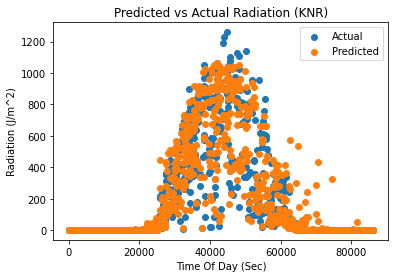

In [ ]:
yscale = df['Radiation'][:,np.newaxis]

scalerY = StandardScaler()
scalerY.fit_transform(yscale)

ypred = y_pred_test[:,np.newaxis]
ypred = scalerY.inverse_transform(ypred)

ytest = y_test[:,np.newaxis]
ytest = scalerY.inverse_transform(ytest)

timeScale = df['TimeOfDay'][:,np.newaxis]

scalerTime = StandardScaler()
scalerTime.fit_transform(timeScale)

xtest = X_test['TimeOfDay'][:,np.newaxis]
time = scalerTime.inverse_transform(xtest)

plt.figure()
plt.scatter(time[0:1000],ytest[0:1000])
plt.scatter(time[0:1000],ypred[0:1000])
plt.title("Predicted vs Actual Radiation (KNR)")
plt.ylabel('Radiation (J/m^2)')
plt.xlabel('Time Of Day (Sec)')
plt.legend(['Actual','Predicted'])


# Random Forest Regressor FINALIZED

* Mean Absolute Error: 0.16631227691925787
* Mean Squared Error: 0.11277742632364571
* Root Mean Squared Error: 0.33582350472181915
* Coefficient of Determination: 0.8862465726854497

In [ ]:
from sklearn.ensemble import RandomForestRegressor
params  = {
  'max_depth': [12],
  'max_features': [3], 
  'min_samples_leaf': [4], 
  'min_samples_split': [2],
  'n_estimators': [120]
}


# {'max_depth': 8,10,12,15,20
#  'max_features': 1,2,3,4,5
#  'min_samples_leaf': 2,3,4,5
#  'min_samples_split': 2,4,6
#  'n_estimators': 50,100,125,150,200}

forest = GridSearchCV(RandomForestRegressor(random_state=1),params, n_jobs=-1, verbose=1,cv=5)
forest.fit(X_train_pca4,y_train)

y_pred_test = forest.predict(X_test_pca4)
y_pred_train = forest.predict(X_train_pca4)

print('Measures of Error: Test Set')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Coefficient of Determination:' , metrics.r2_score(y_test,y_pred_test))
print()
print('Measures of Error: Train Set')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Coefficient of Determination:' , metrics.r2_score(y_train,y_pred_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Measures of Error: Test Set
Mean Absolute Error: 0.16530935909797564
Mean Squared Error: 0.11096446005890916
Root Mean Squared Error: 0.33311328412254765
Coefficient of Determination: 0.8880752287644385

Measures of Error: Train Set
Mean Absolute Error: 0.13648795118282142
Mean Squared Error: 0.0764200678366559
Root Mean Squared Error: 0.2764417982806795
Coefficient of Determination: 0.9237941042503759


# Unstandardized Plot of Prediction Vs Actual (First 1000 pts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

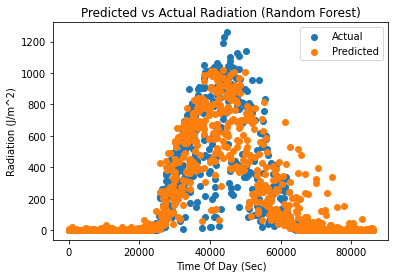

In [ ]:
yscale = df['Radiation'][:,np.newaxis]

scalerY = StandardScaler()
scalerY.fit_transform(yscale)

ypred = y_pred_test[:,np.newaxis]
ypred = scalerY.inverse_transform(ypred)

ytest = y_test[:,np.newaxis]
ytest = scalerY.inverse_transform(ytest)

timeScale = df['TimeOfDay'][:,np.newaxis]

scalerTime = StandardScaler()
scalerTime.fit_transform(timeScale)

xtest = X_test['TimeOfDay'][:,np.newaxis]
time = scalerTime.inverse_transform(xtest)

plt.figure()
plt.scatter(time[0:1000],ytest[0:1000])
plt.scatter(time[0:1000],ypred[0:1000])
plt.title("Predicted vs Actual Radiation (Random Forest)")
plt.ylabel('Radiation (J/m^2)')
plt.xlabel('Time Of Day (Sec)')
plt.legend(['Actual','Predicted'])


# Multi Layer Perceptron Regression FINALIZED
* Mean Absolute Error: 0.1897939721299991
* Mean Squared Error: 0.12283204951816734
* Root Mean Squared Error: 0.3504740354408117
* Coefficient of Determination: 0.8761049345401448

In [ ]:
#DONT RUN, TAKES LONG FOR GRID SEARCH
#hyperparameters are intuition based for our data
#not too bad to train

params = {
    'hidden_layer_sizes' : [ (100,) ,(100,10), (150,30), (50,100)],
    'solver' : ["adam"],
    'activation': ["relu"]
}

mlp = GridSearchCV(MLPRegressor(),params,verbose=1,n_jobs=-1,cv=5)
mlp.fit(X_train_pca4,y_train)
y_pred_test = mlp.predict(X_test_pca4)
y_pred_train = mlp.predict(X_train_pca4)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_test))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Coefficient of Determination:', metrics.r2_score(y_train,y_pred_train))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Mean Absolute Error: 0.2350396221430059
Mean Squared Error: 0.1659957087971078
Root Mean Squared Error: 0.4074257095436023
Coefficient of Determination: 0.8325677273305536
Mean Absolute Error: 0.23629272596620912
Mean Squared Error: 0.16587632594158017
Root Mean Squared Error: 0.40727917445111306
Coefficient of Determination: 0.8345885529825267


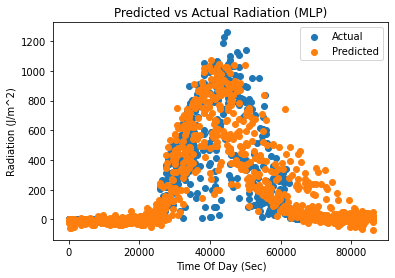

In [ ]:
#non grid search version
mlp = MLPRegressor(activation='relu',hidden_layer_sizes=(50,100), solver='adam')
mlp.fit(X_train_pca4,y_train)
y_pred_test = mlp.predict(X_test_pca4)
y_pred_train = mlp.predict(X_train_pca4)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_test))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Coefficient of Determination:', metrics.r2_score(y_train,y_pred_train))




# Unstandardized Plot of Prediction Vs Actual (First 1000 pts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


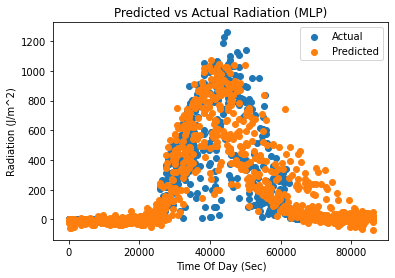

In [ ]:
ypred = y_pred_test[:,np.newaxis]
ypred = scalerY.inverse_transform(ypred)

ytest = y_test[:,np.newaxis]
ytest = scalerY.inverse_transform(ytest)

plt.figure()
plt.scatter(time[0:1000],ytest[0:1000])
plt.scatter(time[0:1000],ypred[0:1000])
plt.title("Predicted vs Actual Radiation (MLP)")
plt.ylabel('Radiation (J/m^2)')
plt.xlabel('Time Of Day (Sec)')
plt.legend(['Actual','Predicted'])


# Loss Curve

Text(0.5, 0, 'Epochs')

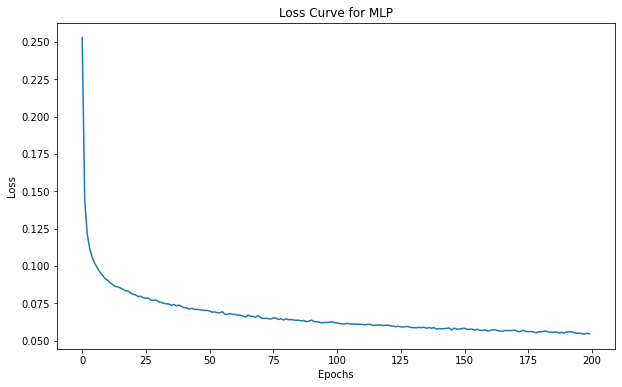

In [ ]:
#loss vs epochs
#loss curve
plt.figure(figsize=(10,6))
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve for MLP")
plt.ylabel("Loss")
plt.xlabel("Epochs")

# Support Vector Regression FINALIZED
* Mean Absolute Error: 0.19770537410844416
* Mean Squared Error: 0.12988601770679858
* Root Mean Squared Error: 0.3603970278828595
* Coefficient of Determination: 0.8689899197381411

In [ ]:
#able to determine list of parameters through repeated grid search across a wide range of parameters
# params = {
#     "kernel" : ["rbf"],
#     "gamma" : ["scale","auto"]
# }

# svr = GridSearchCV(SVR(),params,verbose = 1, n_jobs=-1, cv = 5)
svr = SVR(kernel = 'rbf', gamma = 'scale')
svr.fit(X_train_pca4, y_train)
y_pred_test = svr.predict(X_test_pca4)
y_pred_train = svr.predict(X_train_pca4)



print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_test))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Coefficient of Determination:', metrics.r2_score(y_train,y_pred_train))

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


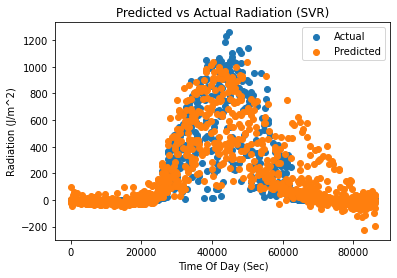

In [ ]:
ypred = y_pred_test[:,np.newaxis]
ypred = scalerY.inverse_transform(ypred)

ytest = y_test[:,np.newaxis]
ytest = scalerY.inverse_transform(ytest)

plt.figure()
plt.scatter(time[0:1000],ytest[0:1000])
plt.scatter(time[0:1000],ypred[0:1000])
plt.title("Predicted vs Actual Radiation (SVR)")
plt.ylabel('Radiation (J/m^2)')
plt.xlabel('Time Of Day (Sec)')
plt.legend(['Actual','Predicted'])
